# Capstone Project: Predicting Airfare for New Market Entrants
## Doug Haunsperger, June 2024

### Section A - Research Question

In this project, I have modeled commercial airfare data from the US Department of Transportation. The question posed was, “Can airfares between city pairs be accurately modeled using a random forest regression model based on characteristics of the cities and routes involved?”

Inaugurating service to a new city can be an expensive proposition for air carriers. Airlines will need office and counter space at the new terminal and new workers to staff the operation. They will also need to train flight crews on procedures at the new airport, to pay for takeoff and landing slots, and potentially purchase or lease new aircraft to expand their fleet.  To ensure a return on this investment, a carrier needs to have a good idea of what revenue they are likely to make, which consists of passenger count and the average fare charged to each passenger. This project models the airfare portion of this equation.

The hypothesis to be tested was that “a random forest regressor with a root mean square error of $50 or less can be created using the available data” versus the null hypothesis that it is not possible to create such a model with the available features.


### Section B - Data Collection

I hypothesized that a sufficiently accurate model could be built using data on route distance, existing carriers servicing the route, carrier market share for the route, the city size, and fares being charged by incumbent carriers. The U.S. Department of Transportation publishes a quarterly Domestic Airline Consumer Airfare Report which advantageously includes the data I wanted to use except for city population (US DOT, 2020). I initially was planning to use Table 1 from this report, which includes “the number of one-way passenger trips per day, the nonstop distance, the average market fare, and identifies the airlines with the largest market share and the lowest average fare” for the “1,000 largest city-pair markets in the 48 contiguous states” (US DOT, 2021). The disadvantage of using table 1 is that cities are identified in a way that makes it difficult to merge with population tables from the US Census. For instance, city names can be combined, or refer to an area, such as “Dallas/Fort Worth, TX” or “Miami, FL (Metropolitan Area)”. 

Faced with this hurdle, I decided instead to replace city size in my model with airport usage. Table 1a in the report provides the same data, but only for flights that originate or end in a city with 2 or more airports (US DOT, 2021). Hence, it also includes an airport code for the route. I was then able to combine this table with data from the Federal Aviation Administration on ‘enplanements’ (passengers serviced) at each airport in America (FAA, 2023).


### Section C - Data Extraction and Preparation

To extract the necessary data for analysis, I began by opening the Table1a CSV in Excel. This file includes over 244,000 records going back more than a quarter century. I first set up a filter on the feature names (column headers) and selected only the year 2022, since that matches the airport usage data I have from the FAA.

![Figure 1](https://github.com/dhaunsperger/WGU_Portfolio/blob/main/Capstone/img/Fig1.png?raw=true)

![Figure 2](https://github.com/dhaunsperger/WGU_Portfolio/blob/main/Capstone/img/fig2.png?raw=true)

I then merged in the FAA data by using a VLOOKUP formula on the remaining ~7800 rows: 

`=VLOOKUP(J4003,'[cy22-commercial-service-enplanements.xlsx]ChangeinRevenuePassengerEnplan '!$D:$I,6,FALSE)`

Checking the values for `#N/A` afterwards reveals that 2 airports are not found in the FAA data – AZA (Phoenix/Mesa Gateway) and FCA (Kalispell/Glacier Park Int’l). I found that this was due to a conflict between the International Air Transport Authority (IATA) code used in the Consumer Airfare Report and the FAA locator ID used in the FAA data. “Many [FAA] LIDs are the same as their corresponding IATA codes, but there are exceptions” (Pilot Institute, 2024). 


![Figure 3](https://github.com/dhaunsperger/WGU_Portfolio/blob/main/Capstone/img/fig3.png?raw=true)

I replaced these values with the corresponding FAA LIDs of IWA and GPI, respectively, and then re-exported the filtered and merged data as a CSV file. This CSV file is attached to the submission as 'Consumer_airfare_filtered_with_pax_counts_corr.csv'.

While I could have done everything in Python/Pandas, Excel made it very easy to merge the data using a one-line VLOOKUP function. One disadvantage of using Excel was that the process of removing the non-2022 data was more cumbersome than it would have been in Pandas. I had to create a filter, select 2022, copy all the filtered rows and paste them as values in a new worksheet. In Pandas, this could have been one or two lines of code.

From this point, I did use Python, including the Pandas, Numpy, and Scikit-learn packages. This code is below.

In [26]:
# Package import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree

To begin, I read the CSV created in Excel to a Pandas DataFrame

Next, I print and count the unique airports included in this data - these include many large airports such as JFK, LAX, DEN, ATL, ... as well as smaller airports such as SRQ (Sarasota/Bradenton FL), GPI (Glacier Park Int'l), ABQ (Albuquerque, NM), etc. In all, I have data on 146 airports.

In [2]:
df = pd.read_csv('Consumer_airfare_filtered_with_pax_counts_corr.csv')
unique_arpts = np.unique(np.concatenate((df.airport_1.unique(), df.airport_2.unique())))
print(unique_arpts)
print(unique_arpts.shape)

['ABE' 'ABQ' 'ACK' 'ACY' 'ALB' 'AMA' 'ASE' 'ATL' 'ATW' 'AUS' 'AVL' 'BDL'
 'BGR' 'BHM' 'BIL' 'BIS' 'BLI' 'BNA' 'BOI' 'BOS' 'BTV' 'BUF' 'BUR' 'BWI'
 'BZN' 'CAE' 'CAK' 'CHO' 'CHS' 'CID' 'CLE' 'CLT' 'CMH' 'COS' 'CVG' 'DAL'
 'DAY' 'DCA' 'DEN' 'DFW' 'DSM' 'DTW' 'ECP' 'EGE' 'ELP' 'EUG' 'EWR' 'EYW'
 'FAR' 'FAT' 'FLL' 'FNT' 'FSD' 'FWA' 'GEG' 'GPI' 'GRR' 'GSO' 'GSP' 'HOU'
 'HPN' 'HRL' 'HSV' 'HVN' 'IAD' 'IAH' 'ICT' 'ILM' 'IND' 'ISP' 'IWA' 'JAC'
 'JAN' 'JAX' 'JFK' 'LAS' 'LAX' 'LBB' 'LCK' 'LGA' 'LGB' 'LIT' 'MAF' 'MCI'
 'MCO' 'MDW' 'MEM' 'MFR' 'MHT' 'MIA' 'MKE' 'MSN' 'MSP' 'MSY' 'MVY' 'MYR'
 'OAK' 'OKC' 'OMA' 'ONT' 'ORD' 'ORF' 'ORH' 'PAE' 'PBI' 'PDX' 'PHF' 'PHL'
 'PHX' 'PIE' 'PIT' 'PNS' 'PSC' 'PSP' 'PVD' 'PVU' 'PWM' 'RDM' 'RDU' 'RIC'
 'RNO' 'ROC' 'RSW' 'SAN' 'SAT' 'SAV' 'SBA' 'SDF' 'SEA' 'SFO' 'SJC' 'SLC'
 'SMF' 'SNA' 'SRQ' 'STL' 'STS' 'SWF' 'SYR' 'TLH' 'TPA' 'TUL' 'TUS' 'TYS'
 'VPS' 'XNA']
(146,)


In [3]:
df.describe()


,Year,quarter,citymarketid_1,citymarketid_2,airportid_1,airportid_2,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,pax_city1,pax_city2
count,7809.0,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7809.000000,7803.000000,7803.000000,7803.000000,7803.000000,0.0,0.0,7.809000e+03,7.809000e+03
mean,2022.0,2.505570,31540.283263,32179.191958,12402.332693,13202.328083,1187.468178,381.530158,249.667511,0.700805,248.721329,0.515483,210.424337,NaN,NaN,1.103235e+07,1.022579e+07
std,0.0,1.113558,1106.512214,1249.705736,1419.797617,1421.251193,687.753732,598.901879,89.723644,0.220377,96.662674,0.338281,84.630568,NaN,NaN,1.179642e+07,8.977560e+06
min,2022.0,1.000000,30135.000000,30189.000000,10135.000000,10466.000000,148.000000,0.000000,67.910000,0.234100,67.910000,0.010000,50.400000,NaN,NaN,7.009800e+04,8.008900e+04
25%,2022.0,2.000000,30721.000000,30977.000000,11066.000000,12197.000000,643.000000,38.000000,186.440000,0.508850,182.605000,0.203300,150.340000,NaN,NaN,1.716904e+06,2.204395e+06
50%,2022.0,3.000000,31295.000000,32337.000000,12266.000000,13303.000000,1020.000000,158.000000,234.000000,0.690000,232.650000,0.463600,199.160000,NaN,NaN,5.536313e+06,7.241882e+06
75%,2022.0,3.000000,32467.000000,33195.000000,13342.000000,14570.000000,1671.000000,457.000000,300.820000,0.924450,302.090000,0.878000,257.315000,NaN,NaN,1.744378e+07,1.436746e+07
max,2022.0,4.000000,35412.000000,35412.000000,15919.000000,15919.000000,2724.000000,6439.000000,956.410000,1.000000,1091.020000,1.000000,870.000000,NaN,NaN,4.539600e+07,3.534514e+07


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7809 entries, 0 to 7808
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tbl             7809 non-null   object 
 1   Year            7809 non-null   int64  
 2   quarter         7809 non-null   int64  
 3   citymarketid_1  7809 non-null   int64  
 4   citymarketid_2  7809 non-null   int64  
 5   city1           7809 non-null   object 
 6   city2           7809 non-null   object 
 7   airportid_1     7809 non-null   int64  
 8   airportid_2     7809 non-null   int64  
 9   airport_1       7809 non-null   object 
 10  airport_2       7809 non-null   object 
 11  nsmiles         7809 non-null   int64  
 12  passengers      7809 non-null   int64  
 13  fare            7809 non-null   float64
 14  carrier_lg      7803 non-null   object 
 15  large_ms        7803 non-null   float64
 16  fare_lg         7803 non-null   float64
 17  carrier_low     7803 non-null   o

`tbl`, `Year` are the same for all records - these columns will be dropped. `Geocoded_City[1,2]` are null for all records - these columns will also be dropped. `tbl1apk` is a concatenation of several other columns and is not useful; it will likewise be dropped.
The `info()` function shows that six records do not have market share data - I will drop these records. 


In [5]:
df=df.drop(columns=['tbl','Year','Geocoded_City1','Geocoded_City2','tbl1apk'])
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7803 entries, 0 to 7808
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   quarter         7803 non-null   int64  
 1   citymarketid_1  7803 non-null   int64  
 2   citymarketid_2  7803 non-null   int64  
 3   city1           7803 non-null   object 
 4   city2           7803 non-null   object 
 5   airportid_1     7803 non-null   int64  
 6   airportid_2     7803 non-null   int64  
 7   airport_1       7803 non-null   object 
 8   airport_2       7803 non-null   object 
 9   nsmiles         7803 non-null   int64  
 10  passengers      7803 non-null   int64  
 11  fare            7803 non-null   float64
 12  carrier_lg      7803 non-null   object 
 13  large_ms        7803 non-null   float64
 14  fare_lg         7803 non-null   float64
 15  carrier_low     7803 non-null   object 
 16  lf_ms           7803 non-null   float64
 17  fare_low        7803 non-null   float6

#### Select target feature and candidate explanatory features

In [6]:
# Target variable
target='fare'
# Quantitative explanatory
quant_cols=['nsmiles', 'passengers', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low', 'pax_city1', 'pax_city2']
# Categorical explanatory
cat_cols = ['quarter', 'carrier_lg', 'carrier_low', 'airport_1', 'airport_2']


#### Plot distributions and check for outliers

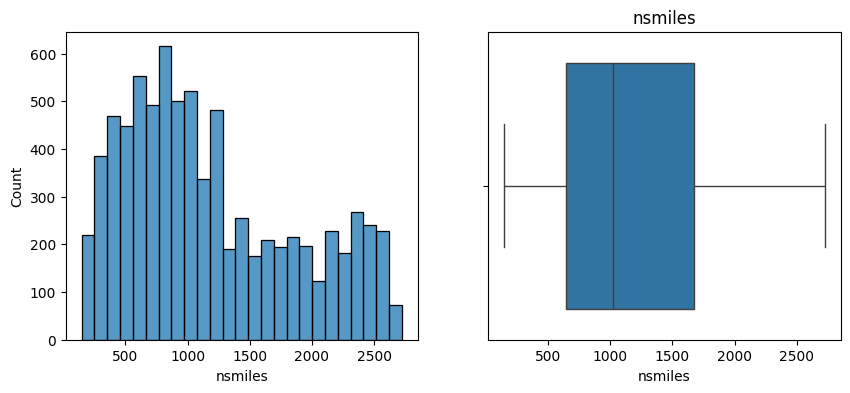

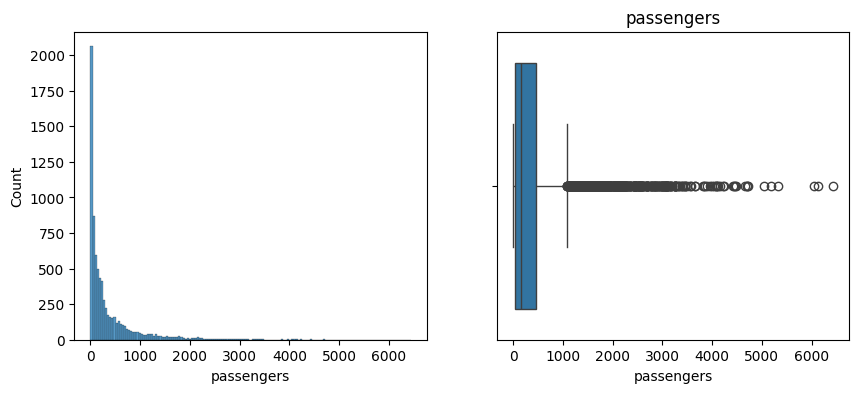

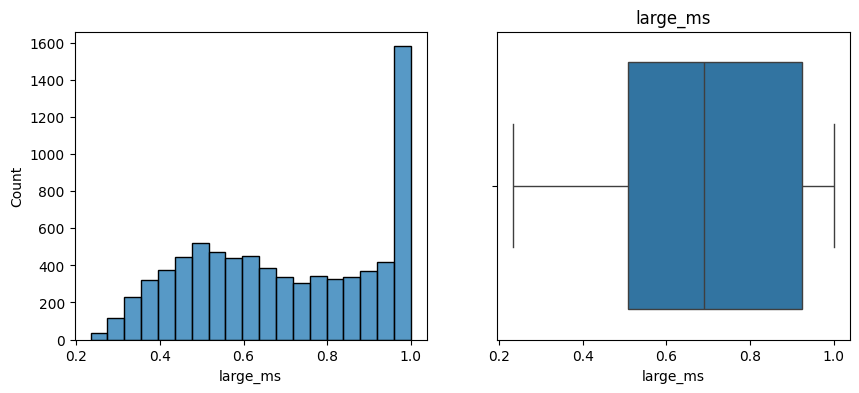

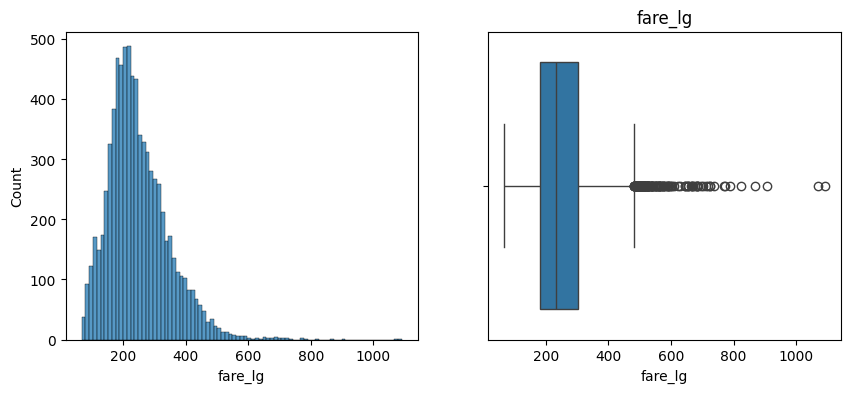

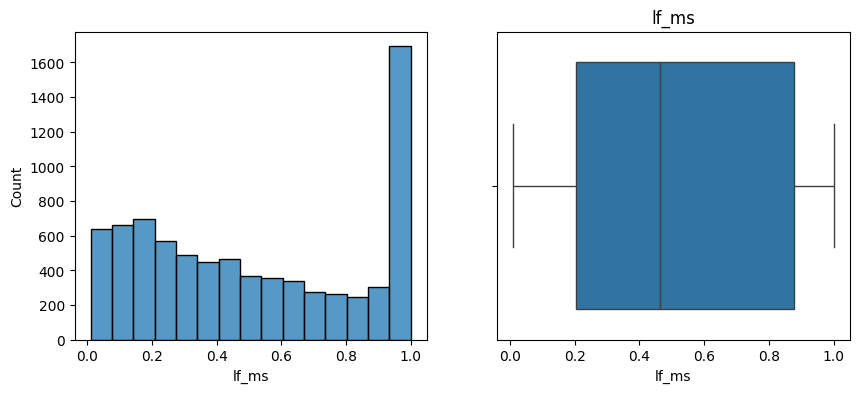

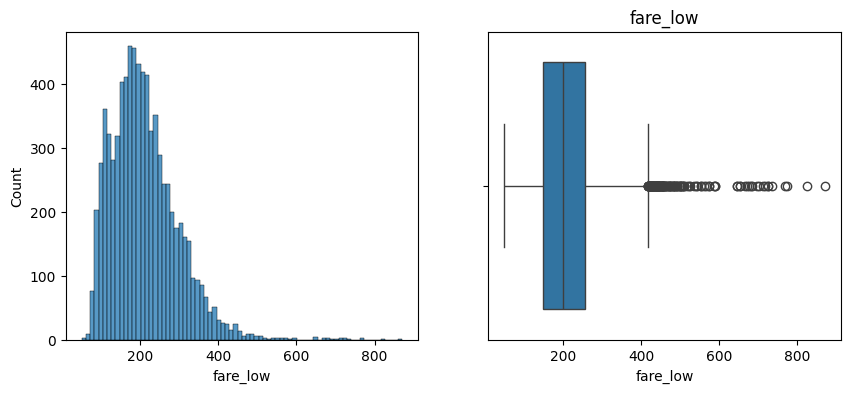

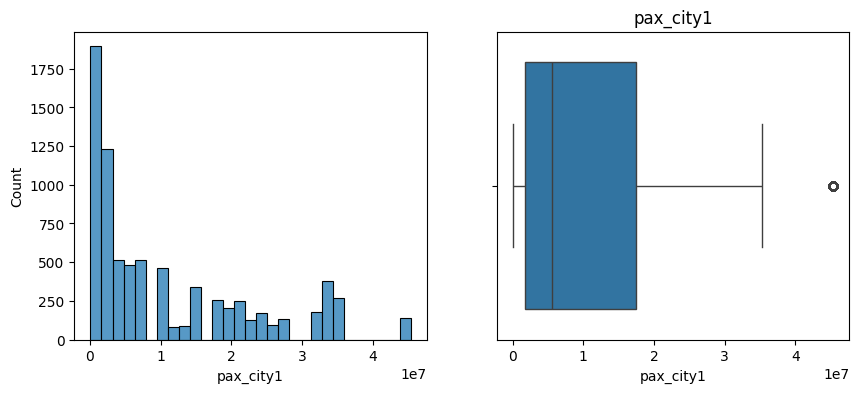

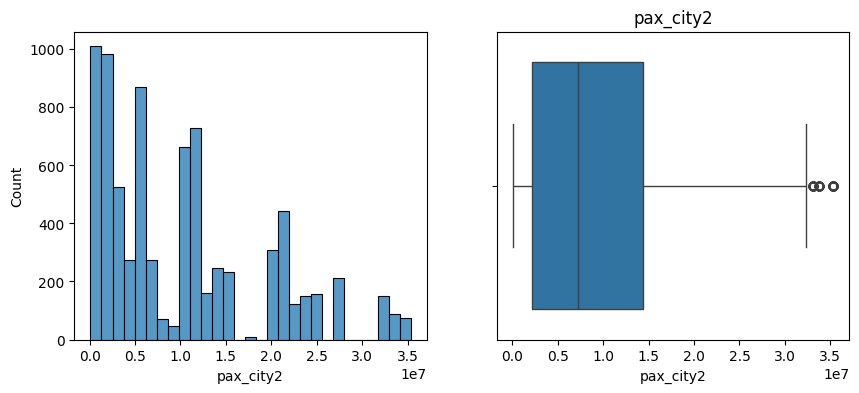

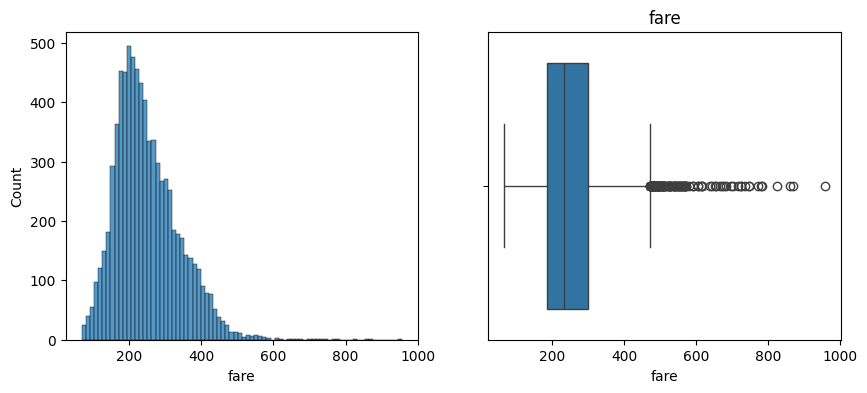

In [7]:
# Choose only the quantitative columns
for col in (quant_cols + [target]):
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df[col], ax=axs[0])
    plt.title(col)
    sns.boxplot(df[col], orient='h', ax=axs[1])
    plt.title(col)
    plt.show()


Passenger counts and fare variables have skewed distributions, with many outliers to the right of the curve. They look to be good candidates for log transformation to achieve a more normal distribution. First I must remove the 164 0-count rows from the data (which are likely erroneous anyway).

In [8]:
df[(df.passengers == 0)].shape

(164, 20)

In [9]:
pass_outliers = df[(df.passengers == 0)]
df.drop(df[(df.passengers == 0)].index, inplace=True)
df.shape

(7639, 20)

In [10]:
# Do a log transformation on passenger counts and fares to produce more normally distributed values
#df.passengers = np.log(df.passengers)
#df.pax_city1 = np.log(df.pax_city1)
#df.pax_city2 = np.log(df.pax_city2)
#df.fare_lg = np.log(df.fare_lg)
#df.fare_low = np.log(df.fare_low)
df.fare = np.log(df.fare)

I originally did a log transform of all passenger and fare data. I subsequently learned that for the Random Forest algorithm, it is not necessary to do transformations of the input variables: "all 1-1 transformations (e.g. log [...] transformation of positive numbers, standardization, [...] etc.) have no effect for random forest, XGBoost, LightGBM and similar algorithms that pick cut-points in variables" (Bjorn, 2021). I chose to keep the log transform on the target variable.

In [11]:
namechg_dict = {'fare':'log_fare'}
""" {'passengers':'log_pax', 'pax_city1': 'log_pax_city1', 'pax_city2':'log_pax_city2', \
               # 'fare_lg':'log_fare_lg', 'fare_low':'log_fare_low', \ 
               Removed since no longer doing log transforms of these variables  """ 
                
df.rename(columns=namechg_dict, inplace=True)
# quant_cols = [namechg_dict.get(item, item) for item in quant_cols]
target = 'log_fare'

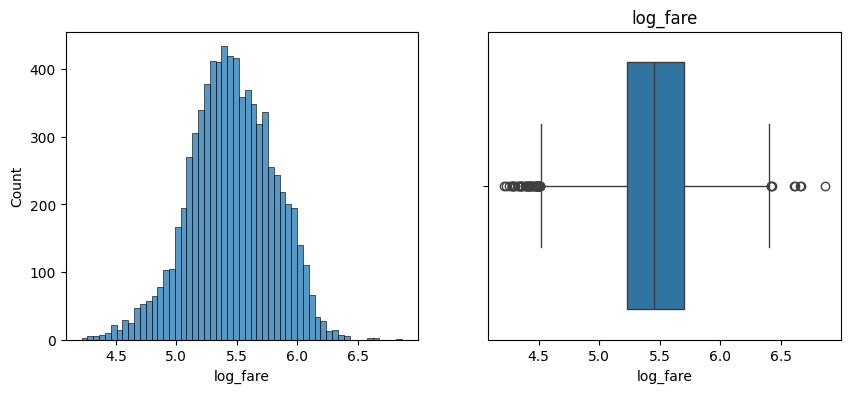

In [12]:
# for col in (quant_cols + [target]):
for col in ([target]):
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df[col], ax=axs[0])
    plt.title(col)
    sns.boxplot(df[col], orient='h', ax=axs[1])
    plt.title(col)
    plt.show()

After log transformation, the `log_fare` column shows a more normal distribution. There are some long tails to both sides, but no egregious outliers. I choose to keep all remaining data for a final count of 7639 records.

#### Treat categorical variables

In [13]:
for col in cat_cols:
    print(df[col].unique())

[1 2 3 4]
['WN' 'AA' 'UA' 'DL' 'B6' 'NK' 'AS' 'G4' 'F9' 'SY' 'MX' 'XP' '3M']
['WN' 'AA' 'DL' 'UA' 'B6' 'NK' 'F9' 'AS' 'G4' 'SY' 'MX' '3M' 'XP']
['ABQ' 'ACY' 'COS' 'DAL' 'DFW' 'PIT' 'HSV' 'ALB' 'AMA' 'DEN' 'ASE' 'ATL'
 'ATW' 'AUS' 'AVL' 'TUS' 'IWA' 'PHX' 'BDL' 'SEA' 'BGR' 'BHM' 'ELP' 'BIL'
 'BIS' 'CAK' 'CLE' 'BNA' 'BOI' 'BOS' 'MHT' 'PVD' 'BTV' 'BUF' 'BZN' 'BWI'
 'DCA' 'IAD' 'MDW' 'ORD' 'CHS' 'CID' 'CLT' 'CMH' 'LCK' 'STL' 'MYR' 'JAX'
 'DTW' 'DSM' 'HOU' 'IAH' 'MCO' 'EGE' 'VPS' 'EUG' 'EYW' 'FAR' 'FAT' 'MSP'
 'EWR' 'HPN' 'ISP' 'JFK' 'LGA' 'SWF' 'RSW' 'FNT' 'FWA' 'XNA' 'GSP' 'GRR'
 'GSO' 'HRL' 'LAS' 'IND' 'JAC' 'OAK' 'SFO' 'SJC' 'FLL' 'MIA' 'BUR' 'LAX'
 'LGB' 'ONT' 'SNA' 'SDF' 'CVG' 'SMF' 'TPA' 'MCI' 'SAT' 'MEM' 'OMA' 'MKE'
 'MSN' 'MSY' 'SAN' 'ORF' 'PHF' 'PNS' 'OKC' 'PAE' 'PDX' 'PHL' 'PSP' 'PWM'
 'RDM' 'RDU' 'RIC' 'RNO' 'ROC' 'SLC' 'SAV' 'SRQ' 'SYR' 'TYS' 'ABE' 'ACK'
 'BLI' 'CAE' 'DAY' 'JAN' 'LIT' 'GPI' 'MVY' 'CHO' 'HVN']
['DAL' 'DFW' 'PHX' 'BWI' 'DCA' 'IAD' 'MDW' 'ORD' 'HOU' 'IAH' 'EWR' 'HP

I chose to use Label encoding following the recommendation of Castellucci (2021).

In [14]:
# Code ref: https://castelluccipeter.medium.com/random-forest-regression-in-python-7b8d94958caa
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(lambda col: le.fit_transform(col))

# Output prepped data set
df.to_csv('prepped_data.csv', index=False)
df.head()

,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,log_fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,pax_city1,pax_city2
0,0,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,1,14,580,213,5.151382,11,1.0000,172.67,11,1.0000,172.67,2317836,7819129
1,0,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,1,17,580,251,5.213304,1,0.9885,183.37,1,0.9885,183.37,2317836,35345138
2,0,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,1,72,328,481,5.107943,11,0.7070,164.17,11,0.7070,164.17,2317836,21852586
3,0,30140,30852,"Albuquerque, NM","Washington, DC (Metropolitan Area)",10140,10821,1,5,1670,108,5.386282,11,0.5798,214.66,4,0.2049,211.95,2317836,11151169
4,0,30140,30852,"Albuquerque, NM","Washington, DC (Metropolitan Area)",10140,11278,1,15,1670,114,5.681537,1,0.3751,304.32,11,0.3469,267.69,2317836,11553850


I have attached the prepared dataset to the submission as ‘prepped_data.csv’.

### Section D - Analysis

#### Random Forest Regression

I have chosen to use a random forest regressor for my model. The random forest algorithm "combines ensemble learning methods with the decision tree framework to create multiple randomly drawn decision trees from the data" (Behesti, 2022). By using ensemble learning, the algorithm averages together the output of multiple independent decision tree models to minimize the overall error. Random forests differ from traditional descision tree models in one key way: "in addition to sampling the records, the algorithm also samples the variables" (Bruce, 2020, p. 261). A decision tree algorithm, in determining how to create the next branch of the tree, minimizes the Gini impurity based on looking at all variables and potential split points. "With random forests, at each stage of the algorithm, the choice of variable is limited to a random subset of variables" (Bruce, 2020, p. 261).  

Calculating Gini impurity is a method for quantitatively assessing the quality of a candidate decision tree split. "Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the [branch] if it were randomly labeled according to the class distribution" of the branch (Zhou, 2019).

An advantage of using random forest over traditional decision trees is a reduction of overfitting. Per Castellucci, a "common problem with decision trees alone is overfitting, random forests reduce overfitting since the final [...] regression problems return the mean of the the individual trees" (2021).

One downside to the random forest algorithm is that there is no a priori way to choose the number or depth of the trees, or other hyperparameters. These must be found by "trial and error", using grid-search cross-validation or another similar method (Castellucci, 2021).

Below, I present my analysis code and results.



#### Train-test split

I use the `train_test_split` function from scikit-learn to split the data into an 80% training set and 20% test set.

In [15]:
ind_var_cols = quant_cols + cat_cols
X = df[ind_var_cols].copy(deep=True)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=4877)

In [16]:
X_train.head()

,nsmiles,passengers,large_ms,fare_lg,lf_ms,fare_low,pax_city1,pax_city2,quarter,carrier_lg,carrier_low,airport_1,airport_2
2218,1107,3086,0.4786,230.57,0.2164,196.61,21852586,22157862,1,2,11,98,91
4273,902,18,0.6325,392.73,0.3072,262.98,1331035,27154885,2,4,1,13,42
2910,1979,72,0.4460,538.28,0.1461,331.08,13751197,2840758,1,4,11,41,64
6125,1342,653,0.7752,295.45,0.1032,113.19,10382573,10266324,3,10,6,9,33
2710,1750,119,0.9963,253.80,0.9963,253.80,9650281,1600987,1,11,11,78,47


#### Tuning Hyperparameters

I use a grid search with cross-validation to test parameters for number of estimators and depth of the trees. I fix `n_jobs` to -1, allowing use of all cores on a multiprocessor system. I fix `max_features` to 1.0 (equivalent to `None` or the default) based on the scikit-learn documentation's recommendation that "Empirical good default values are max_features=1.0 or equivalently max_features=None (always considering all features instead of a random subset) for regression problems" (2024).

While the model continues to improve at the max chosen values of 400 estimators and 9-deep trees, the score improvement is minimal. I have therefore chosen to bound the grid search there to minimize computation time. On my personal multi-core PC, this cell takes approximately 40-45 seconds to run. In a GitHub Codespace virtual environment, it takes over 4 minutes.

In [17]:
## Define Grid 
grid = { 
    'n_jobs': [-1],
    'n_estimators': [50, 100, 200, 400],
    'max_features': [1.0],
    'max_depth' : [5,6,7,8,9],
    'random_state' : [4877]
} 
"""
Shorter version to save processing time on subsequent runs

grid = { 
    'n_jobs': [-1],
    'n_estimators': [400],
    'max_features': [1.0],
    'max_depth' : [9],
    'random_state' : [4877]
}

"""
## show start time
print(datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), scoring='neg_root_mean_squared_error', param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)
## show end time
print(datetime.now())


2024-06-07 15:28:36.499643
2024-06-07 15:32:13.274927


Here I create a DataFrame from the cross-validation results and output the results of the runs with the best 5 scores.

In [18]:
res = pd.DataFrame(CV_rfr.cv_results_)
res[res['rank_test_score'] <= 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,5.007310,0.119376,0.090449,0.008214,8,1.0,400,-1,4877,"{'max_depth': 8, 'max_features': 1.0, 'n_estim...",-0.055444,-0.062755,-0.068749,-0.054524,-0.061755,-0.060645,0.005213,5
16,0.716121,0.029272,0.014059,0.000188,9,1.0,50,-1,4877,"{'max_depth': 9, 'max_features': 1.0, 'n_estim...",-0.053611,-0.060162,-0.067722,-0.052053,-0.059778,-0.058665,0.005564,4
17,1.346427,0.025808,0.024305,0.000168,9,1.0,100,-1,4877,"{'max_depth': 9, 'max_features': 1.0, 'n_estim...",-0.053201,-0.060249,-0.067168,-0.051772,-0.059341,-0.058346,0.005516,2
18,2.763949,0.047477,0.047318,0.004618,9,1.0,200,-1,4877,"{'max_depth': 9, 'max_features': 1.0, 'n_estim...",-0.053198,-0.060434,-0.067185,-0.052297,-0.059092,-0.058441,0.005406,3
19,5.515880,0.138415,0.090233,0.008192,9,1.0,400,-1,4877,"{'max_depth': 9, 'max_features': 1.0, 'n_estim...",-0.053053,-0.060361,-0.066942,-0.052227,-0.059008,-0.058318,0.005364,1


In [19]:
rf = CV_rfr.best_estimator_
rf

RandomForestRegressor(max_depth=9, n_estimators=400, n_jobs=-1,
                      random_state=4877)

Here I run the model on the held out test data, and calculate the mean squared error and root mean squared error. Because I did a log transformation of the target `fare` feature during data preparation, I calculate MSE and RMSE with the exponentiated prediction and test values to get back to the original data range and units (in this case, US dollars). I calculate a root mean square error of $13.15, which is well within the target value of $50 from the hypothesis under test.

In [20]:
prediction = rf.predict(X_test)
# Un-log-transform the target fare to get RMSE in $
mse = mean_squared_error(np.exp(y_test), np.exp(prediction))
rmse = root_mean_squared_error(np.exp(y_test), np.exp(prediction))
print(mse)
print(rmse)

173.3118227436967
13.164794823456106


#### View one tree from the ensemble

Random Forest is an ensemble model, meaning that there are many different decision trees created and an average value of all the estimator trees is used as the output prediction of the model. My model had 400 estimator trees, 9 layers deep. Here I present a view of the top few branches of one of the trees in the final ensemble.

Code ref: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/ (Sampaio, 2023)

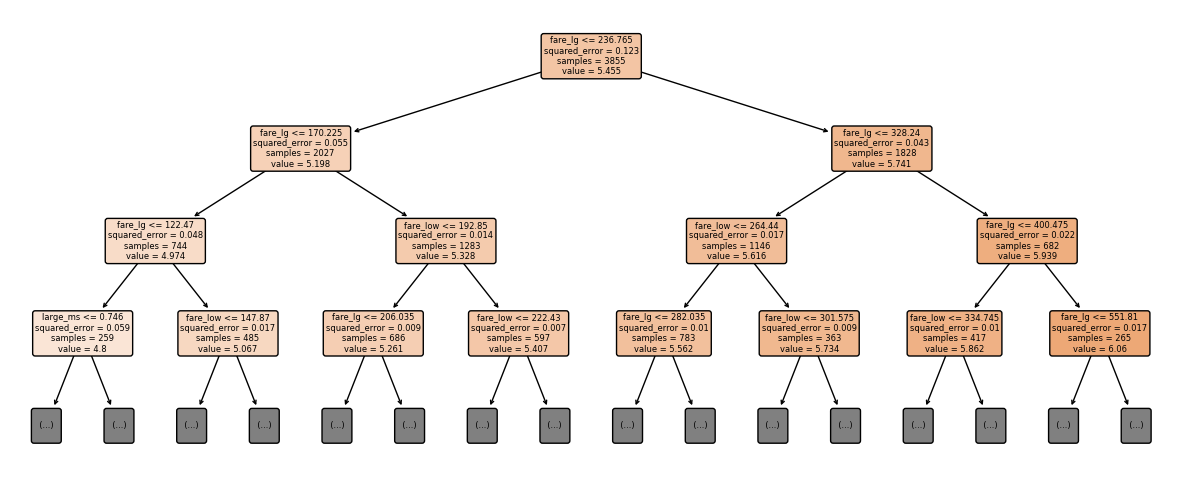

In [21]:
features = X.columns
# Obtain just the first tree
first_tree = rf.estimators_[0]

plt.figure(figsize=(15,6))
tree.plot_tree(first_tree,
               feature_names=features,
               fontsize=6,
               max_depth=3,
               filled=True, 
               rounded=True);

#### Feature Importance
##### Impurity-based
I next calculate the importance of each feature to the model, using two different methods: first, using the built-in `feature_importances_` parameter of the model, which calculates the mean decrease in impurity of each feature. A "feature is considered more important if splitting on that feature significantly decreases the Gini impurity in the nodes of the tree" (Kumar, 2023).

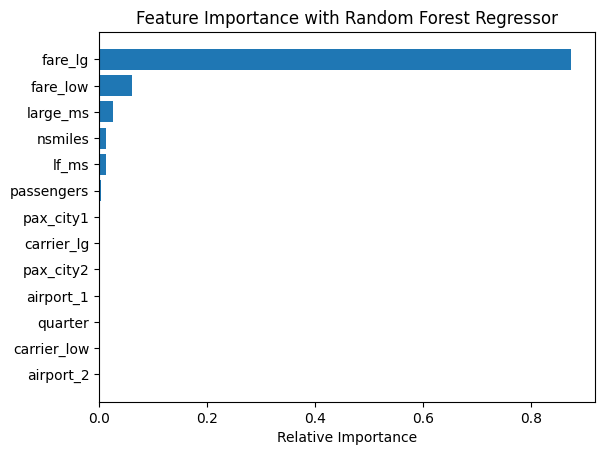

In [22]:
# Code ref: https://vitalflux.com/feature-importance-random-forest-classifier-python/#Interpreting_feature_importance_using_visualization_plot (Kumar, 2023)
importances = rf.feature_importances_
indices = range(len(importances))
names = [X.columns[i] for i in importances.argsort()]
plt.barh(indices, sorted(importances), align='center')
plt.title("Feature Importance with Random Forest Regressor")
plt.yticks(indices, names)
plt.xlabel('Relative Importance')
plt.show()

##### Permutation-based

The downside of the built-in impurity-based calculation is that it is calculated only on the training set. Therefore, variables with no true relation to the larger dataset can show a high importance if they have a high cardinality (Scikit-learn.org, Permutation, 2024).

The solution to this issue is to cross-check the feature importance with a permutation-based method calculated using the test set.

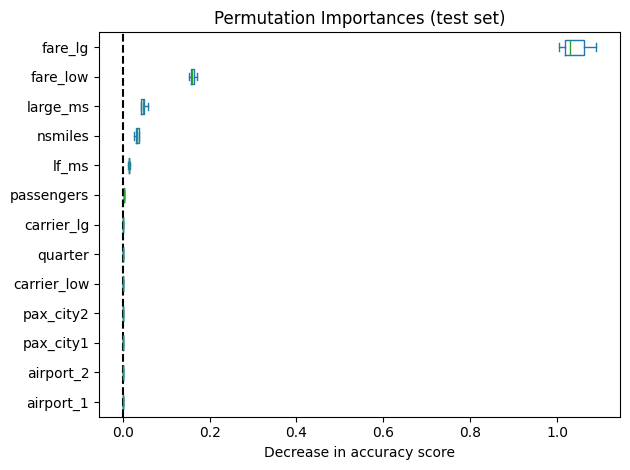

In [23]:
# Code ref: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=4877, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

/tmp/ipykernel_24900/1776686286.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(a)


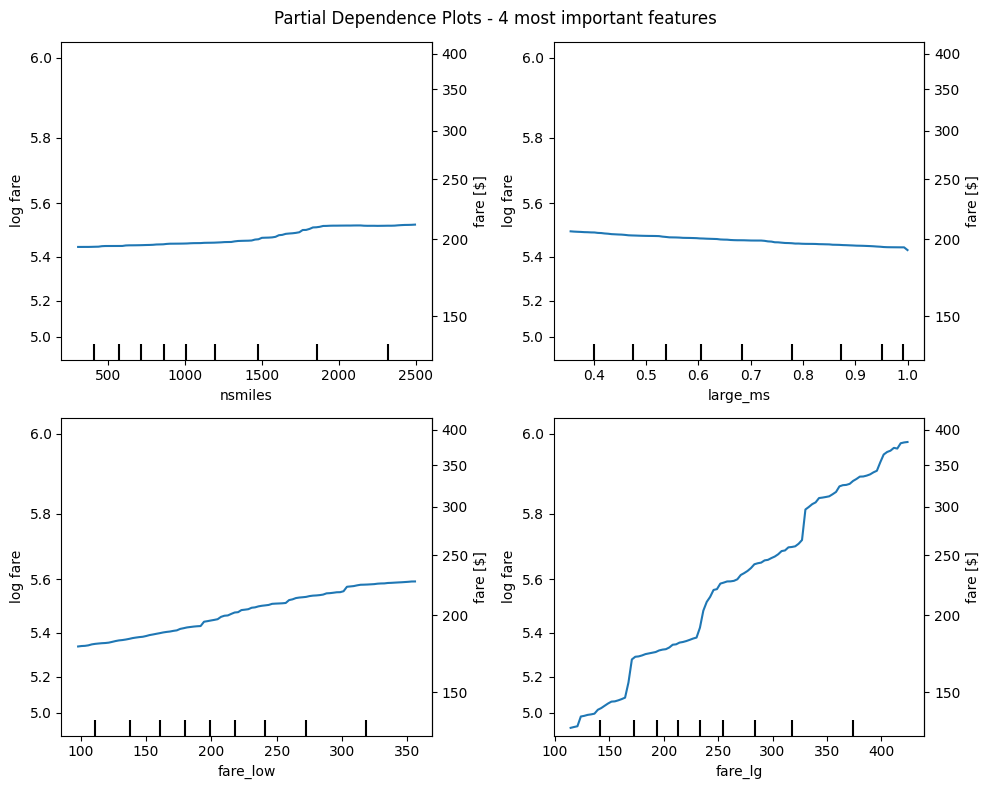

In [24]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
fig.suptitle("Partial Dependence Plots - 4 most important features")

disp = PartialDependenceDisplay.from_estimator(rf, X_train, sorted_importances_idx[-4:],n_cols=2, ax=axs)

# Create 'exp' scale - code ref: https://matplotlib.org/stable/users/explain/axes/axes_scales.html

def forward(a):
    return np.exp(a)

def inverse(a):
    return np.log(a)

for ax_ary in axs:
    for ax in ax_ary:
        ax.set_yscale('function', functions=(forward, inverse)) 
        secax = ax.secondary_yaxis('right', functions=(forward, inverse))
        ax.set_ylabel('log fare')
        secax.set_ylabel('fare [$]')
fig.tight_layout()
plt.show()

Finally, I calculate the $R^{2}$ of the model. At 0.977, it has an extremely good fit.

In [25]:
rf.score(X_test, y_test)

0.9765513474276319

### Section E

### Section F - References

Beheshti, N. (2022, March 2). *Random Forest regression*. Towards Data Science. https://towardsdatascience.com/random-forest-regression-5f605132d19d 

Björn. (2021, November 16). *Log transformation of input features for random forests and xgboost.* [Online forum post]. Cross Validated. https://stats.stackexchange.com/a/552417  

Bruce, Peter, et al. <u>Practical Statistics for Data Scientists : 50+ Essential Concepts Using R and Python</u>, O'Reilly Media, Incorporated, 2020. ProQuest Ebook Central, http://ebookcentral.proquest.com/lib/westerngovernors-ebooks/detail.action?docID=6173908.

Castellucci, P. (2021, July 2). *Random Forest Regression in Python.* Medium. https://castelluccipeter.medium.com/random-forest-regression-in-python-7b8d94958caa  

Federal Aviation Administration. (2023, September 5). US Department of Transportation. *CY 2022 Enplanements at All Commercial Service Airports.* https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/cy22_commercial_service_enplanements 

Kumar, A. (2023, December 9). *Feature Importance & Random Forest - Sklearn Python Example.* Analytics Yogi. https://vitalflux.com/feature-importance-random-forest-classifier-python/#Interpreting_feature_importance_using_visualization_plot 

Pilot Institute. (2024, February 7). *Airport codes explained (FAA, ICAO, IATA).* https://pilotinstitute.com/airport-codes-explained/   

Sampaio, C. (2023, November 16). *Definitive Guide to the Random Forest Algorithm with Python and Scikit-Learn.* Stack Abuse. https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/ 

Scikit-learn.org. (2024). *1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking.* Scikit-learn Documentation, v 1.5.0. https://scikit-learn.org/stable/modules/ensemble.html 

Scikit-learn.org. (2024). *Permutation importance vs random forest feature importance (MDI).* Scikit-learn Examples Gallery, v 1.5.0.. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py 

U.S. Department of Transportation. (2020, October 27). *Domestic Airline Consumer Airfare Report.* https://www.transportation.gov/policy/aviation-policy/domestic-airline-consumer-airfare-report  

U.S. Department of Transportation. (2021, January 26). *Air Fare Information for Consumers.* https://www.transportation.gov/policy/aviation-policy/air-fare-information-consumers 

Zhou, V. (2019, March 29). *A simple explanation of Gini impurity*. Victor Zhou [Blog]. https://victorzhou.com/blog/gini-impurity/ 